In [2]:
import torch
import pickle
import os,sys
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../../../")
sys.path.append("../../")

from human_aware_rl.rllib.utils import get_base_ae
from human_aware_rl.dummy.rl_agent import *
from overcooked_ai_py.agents.agent import AgentPair

In [3]:
def load_checkpoint(file_path):
    assert os.path.isfile(file_path)
    with open(file_path, 'rb') as file:
        checkpoint = pickle.load(file)
    return checkpoint["reward_model"], checkpoint['config'], checkpoint['expert_svf']

def reset_dummy_policy(policy):
    if isinstance(policy, DummyPolicy) and hasattr(policy, 'reset'):
        policy.reset()
        
def getVisitation(states, joint_action, env):
    target_player_idx = 0
    num_game = len(states)
    freq = {}
    for game, actions in zip(states,joint_action):
        for s,a in zip(game,actions):
            reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
            reward_features = tuple(reward_features)
            if reward_features not in freq:
                freq[reward_features] = 0
            freq[reward_features] += 1
    
    for state in freq:
        freq[state] /= num_game
    return freq

def getExpertStateFeatures(train_config, left_agent, right_agent):
    mdp_params = train_config["environment_params"]["mdp_params"]
    env_params = train_config["environment_params"]["env_params"]
    ae = get_base_ae(mdp_params, env_params)
    env = ae.env


    agent_pair = AgentPair(left_agent, right_agent)
    results = env.get_rollouts(agent_pair=agent_pair, num_games=1, display=False)
    states = results['ep_states']
    actions = results['ep_actions']

    act = []
    for idx in actions[0]:
        act.append([Action.ACTION_TO_INDEX[idx[0]], Action.ACTION_TO_INDEX[idx[1]]])
    actions = act
    states = states[0]

    target_player_idx = 0
    features = []    
    for s,a in zip(states,actions):
        reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
        features.append(reward_features)
    return features

def min_max_scale(a, b=None):
    # apply min-max scaling, range becomes [0,1]
    if b is None:
        mini = torch.min(a)
        maxi = torch.max(a)
        a = (a - mini) / (maxi - mini)
        return a
    else:
        mini = min(torch.min(a), torch.min(b))
        maxi = max(torch.max(a), torch.max(b))
        a = (a - mini) / (maxi - mini)
        b = (b - mini) / (maxi - mini)
        return a,b

In [4]:
coop_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T27_coop_epoch=35.checkpoint"
noncoop_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T27_noncoop_epoch=20.checkpoint"

cp_reward_model, cp_config, cp_state_visit = load_checkpoint(coop_ckpt)
ncp_reward_model, ncp_config, ncp_state_visit = load_checkpoint(noncoop_ckpt)

In [5]:
ltn_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T2_ltn_epoch=20.checkpoint"
wte_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T2_wte_epoch=30.checkpoint"

ltn_reward_model, ltn_config, ltn_state_visit = load_checkpoint(ltn_ckpt)
wte_reward_model, wte_config, wte_state_visit = load_checkpoint(wte_ckpt)

ltn_ratio = []
wte_ratio = []

In [6]:
# Layout
layout_setups = [
    {
        'layout': 'coop_experiment_1',
        'coop_bot': MAICooperativeAgent(),
        'noncoop_bot': MAINonCoopAgent(),
        'coop_len': 5,
        'noncoop_len': 8
    },
    {
        'layout': 'coop_experiment_2',
        'coop_bot': MAICooperativeAgent(),
        'noncoop_bot': MAINonCoopAgent2(),
        'coop_len': 5,
        'noncoop_len': 9
    },
    {
        'layout': 'coop_experiment_3',
        'coop_bot': MAICooperativeAgent3(),
        'noncoop_bot': MAINonCoopAgent3(),
        'coop_len': 6,
        'noncoop_len': 10
    },
    {
        'layout': 'coop_experiment_4',
        'coop_bot': MAICooperativeAgent4(),
        'noncoop_bot': MAINonCoopAgent4(),
        'coop_len': 6,
        'noncoop_len': 9
    },
    {
        'layout': 'coop_experiment_5',
        'coop_bot': MAICooperativeAgent5(),
        'noncoop_bot': MAINonCoopAgent5(),
        'coop_len': 8,
        'noncoop_len': 5
    },
    {
        'layout': 'coop_experiment_6',
        'coop_bot': MAICooperativeAgent6(),
        'noncoop_bot': MAINonCoopAgent6(),
        'coop_len': 6,
        'noncoop_len': 7
    },
    {
        'layout': 'coop_experiment_7',
        'coop_bot': MAICooperativeAgent7(),
        'noncoop_bot': MAINonCoopAgent7(),
        'coop_len': 10,
        'noncoop_len': 7
    }
]


In [7]:
# Layout and agent setup
layout_idx = 6

cp_config['environment_params']['mdp_params']['layout_name'] = layout_setups[layout_idx]['layout']
cp_config['environment_params']['env_params']['horizon'] = layout_setups[layout_idx]['coop_len']

ncp_config['environment_params']['mdp_params']['layout_name'] = layout_setups[layout_idx]['layout']
ncp_config['environment_params']['env_params']['horizon'] = layout_setups[layout_idx]['noncoop_len']

COOP_BOT_SVF = getExpertStateFeatures(cp_config, layout_setups[layout_idx]['coop_bot'], MAIDummyRightCoopAgent())
NONCOOP_BOT_SVF = getExpertStateFeatures(ncp_config, layout_setups[layout_idx]['noncoop_bot'], MAIDummyRightCoopAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 10.00; : 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]


Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 7.00; : 100%|██████████| 1/1 [00:00<00:00, 234.84it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


In [8]:

def get_stats(reward_model, states):
    lst = []
    for state in states:
        reward = reward_model.get_rewards(state)
        lst.append(reward[0].item())
    lst = torch.tensor(lst)
    return lst

ltn_cp = get_stats(ltn_reward_model, COOP_BOT_SVF)
ltn_np = get_stats(ltn_reward_model, NONCOOP_BOT_SVF)

wte_cp = get_stats(wte_reward_model, COOP_BOT_SVF)
wte_np = get_stats(wte_reward_model, NONCOOP_BOT_SVF)


In [9]:
def min_max_scale_with_avg(a, b):
    # apply min-max scaling, range becomes [0,1]
    mini = min(torch.min(a), torch.min(b))
    maxi = max(torch.max(a), torch.max(b))
    a = torch.sum((a - mini) / (maxi - mini)) / len(a)
    b = torch.sum((b - mini) / (maxi - mini)) / len(b)
    return a,b

# scaled average reward per step
avg_ltn_cp, avg_ltn_np = min_max_scale_with_avg(ltn_cp, ltn_np)
avg_wte_cp, avg_wte_np = min_max_scale_with_avg(wte_cp, wte_np)



In [10]:
wte_ratio.append(avg_wte_cp / avg_wte_np)
ltn_ratio.append(avg_ltn_cp / avg_ltn_np)

In [11]:
print(wte_ratio)
print(ltn_ratio)

[tensor(0.3983)]
[tensor(0.8056)]


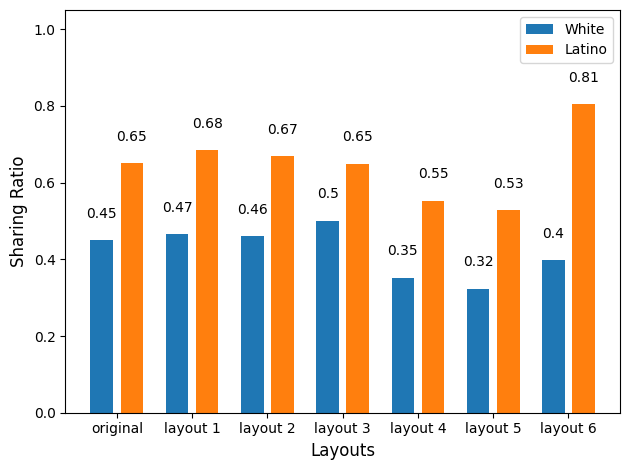

In [12]:
# Data
white = [0.4494, 0.4652, 0.4602, 0.5009, 0.3523, 0.3236, 0.3983]
latino = [0.6505, 0.6844, 0.6692, 0.6495, 0.5530, 0.5283, 0.8056]
layouts = ['original', 'layout 1', 'layout 2', 'layout 3', 'layout 4', 'layout 5', 'layout 6']

# Create an array for x-axis positions
x = np.arange(len(layouts))

# Set the width of the bars and the gap
bar_width = 0.3  # Adjust the bar width as needed
gap = 0.1  # Adjust the gap between pairs of bars

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the "white" bars
bar1 = ax.bar(x - bar_width/2 - gap/2, white, bar_width, label='White')

# Plot the "latino" bars
bar2 = ax.bar(x + bar_width/2 + gap/2, latino, bar_width, label='Latino')

# Set the x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(layouts)

# Add labels and a legend
ax.set_xlabel('Layouts', fontsize=12)
ax.set_ylabel('Sharing Ratio', fontsize=12)
ax.legend()

# Add rounded values on top of the bars (rounded to 2 decimals)
for i, v in enumerate(white):
    ax.text(i - bar_width/2 - gap/2, v + 0.05, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

for i, v in enumerate(latino):
    ax.text(i + bar_width/2 + gap/2, v + 0.05, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

# Set the y-axis limits to make it taller
ax.set_ylim(0, 1.05)  # Adjust the limits as needed

# Show the plot
plt.tight_layout()
plt.savefig('/Users/jasmineli/Downloads/sharing-ratio-modified-env.pdf', bbox_inches='tight')



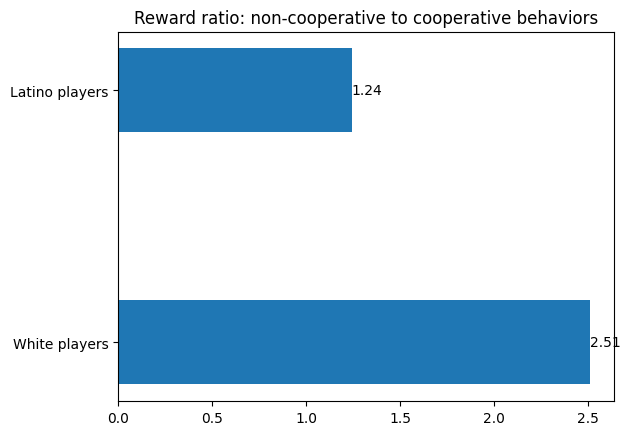

In [13]:
width = 0.1
ratio = [avg_wte_np / avg_wte_cp, avg_ltn_np / avg_ltn_cp]
ind = 0.3 * np.arange(2)
label = ['White players','Latino players']

fig, ax = plt.subplots()
bar = ax.barh(ind + 0.5 * width, ratio, width, 0, align='center')

ratio = ["{:.2f}".format(round(r.item(), 2)) for r in ratio]
plt.bar_label(bar, ratio)

# ax.barh(ind, [coop_noncoop], width, color='olive', label='non-cooperative reward')

ax.set(yticks=ind + 0.5 * width, yticklabels=label) 
ax.set_title('Reward ratio: non-cooperative to cooperative behaviors')
plt.show()

# Plotting reward per feature

In [14]:
FEATURES = [
    'p0 onion dx', 'p0 onion dy', 
    'p0 bridge dx', 'p0 bridge dy', 
    'p0 stove dx', 'p0 stove dy', 
    'p0 orientation(N)', 'p0 orientation(S)', 'p0 orientation(E)', 'p0 orientation(W)',  
    'p0 withOnion', 
    'p1 withOnion',
    'onion on bridge',
    'No. of onion in pot',
    'p0 at (4,3) w/ onion',
    'p0 at (4,2) w/ onion',
    'p0 at (4,1) w/ onion',
    'p0 at (3,1) w/ onion',
    ]

feat = torch.diag(torch.ones(18))

ltn_rew_per_feat = ltn_reward_model.get_rewards(feat).squeeze()
wte_rew_per_feat = wte_reward_model.get_rewards(feat).squeeze()
ncp_reward_per_feat = ncp_reward_model.get_rewards(feat).squeeze()
cp_reward_per_feat = cp_reward_model.get_rewards(feat).squeeze()

ltn_rew_per_feat = min_max_scale(ltn_rew_per_feat)
wte_rew_per_feat = min_max_scale(wte_rew_per_feat)
ncp_reward_per_feat = min_max_scale(ncp_reward_per_feat)
cp_reward_per_feat = min_max_scale(cp_reward_per_feat)

for rew in [ltn_rew_per_feat, wte_rew_per_feat, ncp_reward_per_feat, cp_reward_per_feat]:   
    for i in range(4):
        rew[i] = -1 * rew[i]


In [15]:
import numpy as np 

def plot_bar(rewards1, rewards2, rewards3, rewards4, features, title):
    bar_labels_1 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards1]
    bar_labels_2 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards2]
    bar_labels_3 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards3]
    bar_labels_4 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards4]
    plt.clf()

    plt.figure() 

    n = len(features)
    r = np.arange(n)
    height = 0.5

    bar_1 = plt.barh(r * 4 * height, rewards1, label="latino", height=0.4)
    bar_2 = plt.barh(r * 4 * height + height, rewards2, label="white", height=0.4)
    bar_3 = plt.barh(r * 4 * height + height * 2, rewards3, label="non-coop", height=0.4)
    bar_4 = plt.barh(r * 4 * height + height * 3, rewards4, label="coop", height=0.4)
    plt.xlim([-0.5, 1.2])
    plt.bar_label(bar_1, bar_labels_1)
    plt.bar_label(bar_2, bar_labels_2)
    plt.bar_label(bar_3, bar_labels_3)
    plt.bar_label(bar_4, bar_labels_4)
    plt.yticks(r * 4 * height + 1.5 * height, features)
    plt.legend()
    plt.title(title)
    # plt.plot()
    plt.show
    # plt.savefig('t20_human_reward_comparison.pdf', format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

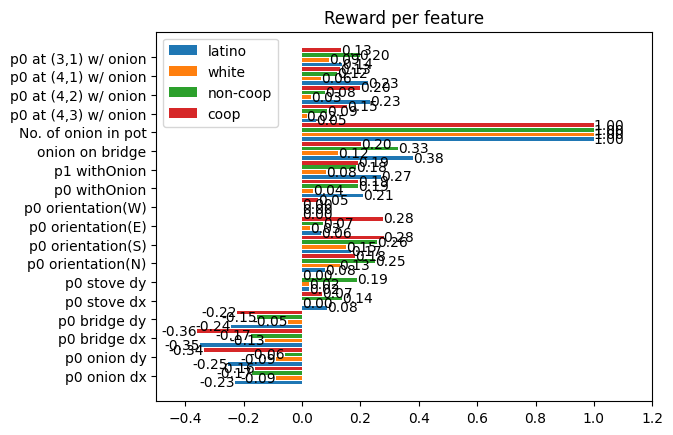

In [16]:
plot_bar(ltn_rew_per_feat, wte_rew_per_feat, ncp_reward_per_feat, cp_reward_per_feat, FEATURES, "Reward per feature")

<Figure size 640x480 with 0 Axes>

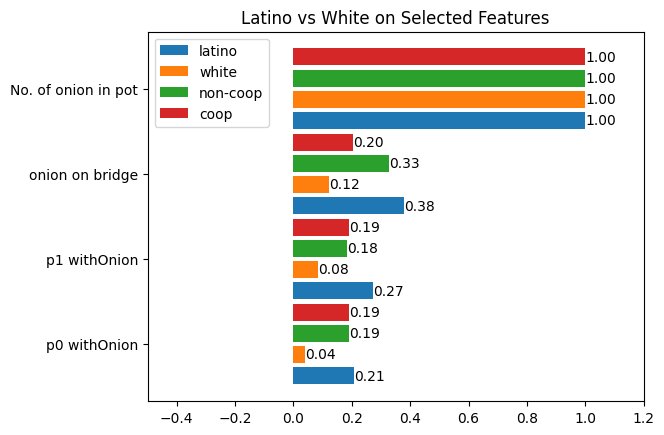

In [17]:
selected_feat_idx = [10, 11, 12, 13]
feature_label = [FEATURES[i] for i in selected_feat_idx]
latino = [ltn_rew_per_feat[i] for i in selected_feat_idx]
white = [wte_rew_per_feat[i] for i in selected_feat_idx]
coop = [cp_reward_per_feat[i] for i in selected_feat_idx]
noncoop = [ncp_reward_per_feat[i] for i in selected_feat_idx]

plot_bar(latino, white, noncoop, coop, feature_label, "Latino vs White on Selected Features")

# plot_bar(latino, white, feature_label, "Latino vs White on Selected Features")

